In [1651]:
import pandas as pd
import pickle
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from scipy import stats
sns.set(font_scale = 1, style = 'darkgrid', rc={'figure.figsize':(7,5)})

Time periods:
1. Baseline period: 2005-2013
2. Intervention period: 2014-2020
3. Evaluation period: 2021-


1. Find the K nearest sponsoring units for each sponsoring unit for each year from 2005 to 2010(or other year)
    - Save distance
2. Sum distances, and find the K sponsoring units with smalles total distance
3. Calculate relative likelihood of unit inviting females, for each unit
4. Now find the sponsoring units that adopted different strategies from 2011 to 2020
    - Unit i have high likelihood of invited females, unit j have low likelihood of inviting females
        - Do this by finding units with large difference of likelihood
5. Increase in female attendees compare to baseline period
    - How is outcome for unit i vs unit j?

When finding the most different units in the interventon period, we substract units j from i. We care about real difference, not absolute. But when comparing different units, we care about normalized difference. Meaning it does not matter if unit i has the biggest or smallest relative likelihood.

The reason that we want the real difference, is that if they fluctuate a lot, and basically cancel each other out, this should not count as a big differrence. 

When finding Change in female attendees is measured in female ratio since the total number of attendees is increasing

# Method

1. Remove sponsoring units that have data for less than 5 years. These are too small for us to see anything.
2. Remove sponsoring units with less than 3 years in baseline. These do not have enough data to compare with
3. Remove sponsoring units with 20 or less researchers from 2005 to 2019
4. remove sponsoring units that is not in the baseline data. This is because we don't have anything to compare with, if it is not in baseline

we try with baseline 2005-2013


As starting point, we only use units with data from the entire period


# Functions

In [2]:
#do some function where we calculate each feature
#def getFeatures(features):
#    if x in features:
#        #calcualte x
#    if i in feaures:
#        ##calculate i

In [363]:
def getFemaleRatio(sponsoringUnits, invited_df, attendees_df, unitCol):
    index = 0
    femaleRatioInv_dict = {}
    femaleRatioAtt_dict = {}
    for i in sponsoringUnits:
        sponsoringUnitInv = invited_df[invited_df[unitCol] == i]
        sponsoringUnitAtt = attendees_df[attendees_df[unitCol] == i]
        invited_crossTab = pd.crosstab(index = sponsoringUnitInv.Year, columns = sponsoringUnitInv.Gender,
                    normalize = "index")['Female'].reset_index().rename(columns = {'Female': 'FemaleRatio_inv'})
        invited_crossTab['SponsoringUnitName'] = i
    
        attendees_crossTab = pd.crosstab(index = sponsoringUnitAtt.Year, columns = sponsoringUnitAtt.Gender,
                    normalize = 'index')['Female'].reset_index().rename(columns = {'Female': 'FemaleRatio_att'})
    
        attendees_crossTab['SponsoringUnitName'] = i
    
        invitedDict = invited_crossTab.to_dict('list')
        attendeesDict = attendees_crossTab.to_dict('list')
        femaleRatioInv_dict[index] = invitedDict
        femaleRatioAtt_dict[index] = attendeesDict
        index += 1

    return femaleRatioInv_dict, femaleRatioAtt_dict

In [364]:
def standardizeColumn(df, columnName):
    standardizedColumn = (df[columnName] - df[columnName].mean())/(df[columnName].std())
    
    return standardizedColumn

In [1234]:
#def KNN(df, features, K):
#    neighborDict = {}
   # unitOrderDict = {}
#    index = 0
   # unit_index = 0
#    df_stand = df.copy()
    
 #   for c in features:
  #      df_stand[c] = standardizeColumn(df_stand, c) #standardize data
    
  #  years = df.Year.unique()
   # for y in years:
    #    year_df = df_stand[df_stand.Year == y]
        
        #do KNN
     #   neighbors = NearestNeighbors(n_neighbors = K, metric = 'manhattan').fit(year_df[features])
      #  kNeighbor_dist, kNeighbor_ind = neighbors.kneighbors(year_df[features])
       # distances = kNeighbor_dist.flatten()
        #threshold = np.quantile(distances, 0.5)
        #indices = kNeighbor_ind.copy().astype(float)
        #indices[~(kNeighbor_dist <= threshold)] = np.nan #set indices to nan if their distance is higher than the threshold

        #now add units
        #unitOrder = year_df.SponsoringUnitName.values.tolist() #list of sponsoring unit(and order of it)
        #for i in range(0,len(unitOrder)):
        #    neighborDict[index] = {'SponsoringUnit': unitOrder[i], 'Year': y, 'Neighbor': indices[i,1:]} #don't select unit itself as neighbor
        #    index += 1

      #  unitOrderDict[unit_index] = {'Year': y, 'UnitOrder': unitOrder, 'UnitIndex': np.arange(0, len(unitOrder))}
       # unit_index += 1
#    neighbor_df = pd.DataFrame.from_dict(neighborDict, orient = 'index').explode('Neighbor').dropna(subset = 'Neighbor')
 #   unitOrder_df = pd.DataFrame.from_dict(unitOrderDict, orient = 'index').explode(['UnitOrder', 'UnitIndex']) #to ensure that we get the right name of the neighbors
 #   return neighbor_df, unitOrder_df

In [1283]:
#get distances
def KNN_distances(df, features):
    neighborDict = {}
    index = 0
    df_stand = df.copy()
    units = df.SponsoringUnitName.unique()
    #unitDist = np.zeros((len(units), len(units)))

    for c in features:
        df_stand[c] = standardizeColumn(df_stand, c) #standardize data
        
    years = df.Year.unique()
    for y in years:
        year_df = df_stand[df_stand.Year == y]
        
        #do KNN
        neighbors = NearestNeighbors(n_neighbors = len(units), metric = 'manhattan').fit(year_df[features])
        kNeighbor_dist, kNeighbor_ind = neighbors.kneighbors(year_df[features])
        
        for i in range(0, len(units)):
            neighborDict[index] = {'SponsoringUnit': units[i], 'Year': y, 'Neighbor': kNeighbor_ind[i,1:], 'Distance': kNeighbor_dist[i,1:]} #don't select unit itself as neighbor
            index += 1
     
    neighbor_df = pd.DataFrame.from_dict(neighborDict, orient = 'index').explode(['Neighbor', 'Distance'])
    neighborIndex_df = pd.DataFrame(units).rename(columns = {0: 'NeighborUnit'})
    return neighbor_df, neighborIndex_df

In [1312]:
#get similar untis within threshold
def KNN_similarUnits(df, features):
    KNN_df, unitIndex = KNN_distances(df, features) #get distance
    KNN_similarSponsUnits = KNN_df.merge(unitIndex, how = 'left', left_on = 'Neighbor', right_on = unitIndex.index)[['SponsoringUnit', 'Year', 'Distance', 'NeighborUnit']] #add name of NeighborUnit
    distances = KNN_similarSponsUnits.groupby(['SponsoringUnit', 'NeighborUnit']).sum(numeric_only = False) #sum distance for each unit and neighbor
    quantile = distances.Distance.quantile(q = 0.5) #threshold of summed distance
    similarUnits =  distances[distances.Distance <= quantile].reset_index()[['SponsoringUnit', 'NeighborUnit', 'Distance']] #df of units similar enough
  
    return similarUnits

In [1339]:
#is not used
#def findNearestNeighbors(df, K):
#    kNeighborMatch = {}
#    for i in sponsoringUnits:
#        unit_df = df[df.SponsoringUnitName == i]
#        nearestNeighbors = unit_df.nsmallest(K, 'Distances').Neighbors.tolist()
#        kNeighborMatch[i] = nearestNeighbors
    
#    neighbor_df = pd.DataFrame.from_dict(kNeighborMatch, orient = 'index')
#    return neighbor_df

In [619]:
def getDifferentUnits(similarUnits, likelihood_df):
    differentUnits = {}
    for i in similarUnits:
        likelihood_unit = likelihood_df[likelihood_df.SponsoringUnit == i] #relative likelihood for unit
        neighborUnits = list(similarUnits[i].values()) #similar sponsoring units
        mostDifferent_val = 0
        for j in neighborUnits: #loop through similar units
            likelihood_neighbor = likelihood_df[likelihood_df.SponsoringUnit == j] #relative likelihood for each neighbor
            likelihood_difference = np.sum(likelihood_unit.Avg_likelihood - likelihood_neighbor.Avg_likelihood)
            if abs(likelihood_difference) > mostDifferent_val:
                differentUnits[i] = {'DifferentUnits': j, 'AbsoluteDiff': mostDifferent_val}
                mostDifferent_val = likelihood_difference
    return differentUnits

In [1410]:
def getDifferentUnits(units, likelihood_df):
    similarUnit_dict = units.to_dict('records')
    likelihoodDict = {}
    index = 0
    
    for i in similarUnit_dict:
        #unit and its neighbor
        unit_i = i['SponsoringUnit']
        unit_j = i['NeighborUnit']
        
        #likelihood of unit and its neighbor
        likelihood_i = likelihood_df[likelihood_df.SponsoringUnit == unit_i]['Avg_likelihood']
        likelihood_j = likelihood_df[likelihood_df.SponsoringUnit == unit_j]['Avg_likelihood']
        
        #get difference in likelihood
        likelihood_diff = (likelihood_i - likelihood_j).sum()
        likelihoodDict[index] = {'SponsoringUnit': unit_i, 'NeighborUnit': unit_j, 'LikelihoodDifference': likelihood_diff}
        index += 1
        
    likelihoodDiff_df = pd.DataFrame.from_dict(likelihoodDict, orient = 'index') #convert likelihood differences to df
    similarUnits_diff = units.merge(likelihoodDiff_df, how = 'inner', on = ['SponsoringUnit', 'NeighborUnit']) #get difference of similar units(from baseline period)
    
    return similarUnits_diff

In [1512]:
def getRelativeChange(newVal, oldVal):
    change = (newVal - oldVal) / oldVal
    
    return change

In [1513]:
def getChange(units, baseline, evaluation):
    relativeChange_dict = {}
    index = 0
    for i in units:
        baseline_att = baseline[(baseline.SponsoringUnitName == i) & (baseline.SessionType == 'attendee')] #baseline data for attendees in unit i
        
        #get gender ratio
        genderRatio = pd.crosstab(index = baseline_att.Year, columns = baseline_att.Gender, normalize = 'index')
        
        #evaluation
        eval_att = evaluation[(evaluation.SponsoringUnitName == i) & (evaluation.SessionType == 'attendee')] #data for i in evaluation period
        sessionTypeEval = pd.crosstab(index = eval_att.Year, columns = eval_att.Gender, normalize = 'index')
        relativeChange = getRelativeChange(sessionTypeEval.Female.mean(), genderRatio.Female.mean()) #get relative change of female attendees
        relativeChange_dict[index] = {'SponsoringUnit': i, 'RelativeChangeAtt': relativeChange} #save relative change in dictionary
        index += 1
        
    relativeChange_df = pd.DataFrame.from_dict(relativeChange_dict, orient = 'index')
    return relativeChange_df

In [549]:
sponsUnitResearchers = pd.read_pickle("Files/Dataframes/researchers_sponsoringUnits.pkl")

In [550]:
#define invited speakers and attendees
invited = sponsUnitResearchers[sponsUnitResearchers.SessionType == 'invited']
attendees = sponsUnitResearchers[sponsUnitResearchers.SessionType == 'attendee']

In [551]:
#number of years with data for each sponsoring unit for invited speakers and attendees
invitedYearCount = invited.groupby(['SponsoringUnitName', 'Year']).count()['SearchName'].reset_index().groupby('SponsoringUnitName').count().reset_index()
attendeesYearCount = attendees.groupby(['SponsoringUnitName', 'Year']).count()['SearchName'].reset_index().groupby('SponsoringUnitName').count().reset_index()

In [552]:
yearCount_df = invitedYearCount[['SponsoringUnitName', 'Year']].rename(columns = {'Year': 'invitedYears'})
yearCount = yearCount_df.merge(attendeesYearCount[['SponsoringUnitName', 'Year']], how = 'outer', on = 'SponsoringUnitName').rename(columns = {'Year': 'attendeeYears'})

In [553]:
#units with data for all 19 years
units = yearCount[(yearCount.invitedYears == 19) & (yearCount.attendeeYears == 19)].SponsoringUnitName.tolist()

In [554]:
#number of years with data for each sponsoring unit
#yearCount = sponsUnitResearchers.groupby(['SponsoringUnitName', 'Year']).count()['SearchName'].reset_index().rename(columns = {'SearchName': 'UnitSize'}).groupby('SponsoringUnitName').count().reset_index()
#totalSize = sponsUnitResearchers.groupby(['SponsoringUnitName']).count()

In [555]:
#list of sponsoring units with at most data for four years + "None" as sponsoring units
#smallUnits = yearCount[yearCount.Year <= 4].SponsoringUnitName.tolist()
#smallUnits.append(totalSize[totalSize.SearchName <= 20].index.tolist()) #append units with 50 or less researchers
#smallUnits.append(None)

#only choose data for the chosen units
filteredData = sponsUnitResearchers[sponsUnitResearchers.SponsoringUnitName.isin(units)]

In [556]:
#data for 2013 or earlier
baselineData = filteredData[filteredData.Year <= 2013]
interventionData = filteredData[(filteredData.Year > 2013) & (filteredData.Year <= 2020)]
evaluationData = filteredData[filteredData.Year > 2020]

#count of number of years in baseine data for each sponsoring units
#baselineYearCount = baselineData.groupby(['SponsoringUnitName', 'Year']).count().reset_index().groupby('SponsoringUnitName').count()

#baselineUnits = baselineYearCount[baselineYearCount.Year >= 3].index.tolist()

In [557]:
#filter data by removing sponsoring units that were not in baseline data or should be removed
#removeUnits_filtering = filteredData[filteredData.SponsoringUnitName.isin(baselineUnits)]

In [558]:
#define baselineData(again), intrvention data and evaluation data
#baselineData = removeUnits_filtering[removeUnits_filtering.Year <= 2013]
#interventionData = removeUnits_filtering[(removeUnits_filtering.Year > 2013) & (removeUnits_filtering.Year < 2020)]
#evaluationData = removeUnits_filtering[removeUnits_filtering.Year >= 2020]

In [559]:
sizePerYear = baselineData.groupby(['SponsoringUnitName', 'Year']).count()['SearchName'].reset_index().rename(columns = {'SearchName': 'UnitSize'})

In [560]:
invitedBaseline = baselineData[baselineData.SessionType == 'invited']
attendeesBaseline  = baselineData[baselineData.SessionType == 'attendee']

In [561]:
invitedPerYear = invitedBaseline.groupby(['SponsoringUnitName', 'Year']).count()['SearchName'].reset_index().rename(columns = {'SearchName': 'n_invited'})
attendeesPerYear = attendeesBaseline.groupby(['SponsoringUnitName', 'Year']).count()['SearchName'].reset_index().rename(columns = {'SearchName': 'n_attendees'})

In [562]:
#count years with attendees per sponsoring unit
#attendeesYearCount = attendeesPerYear.groupby('SponsoringUnitName').count().reset_index()
#invitedYearCount = invitedPerYear.groupby('SponsoringUnitName').count().reset_index()

In [563]:
#create list of sponsoring units
#sponsoringUnits = units.SponsoringUnitName.tolist()
#units = attendeesYearCount[attendeesYearCount.Year == 6].SponsoringUnitName.tolist()

In [564]:
femaleInv, femaleAtt = getFemaleRatio(units, invitedBaseline, attendeesBaseline, 'SponsoringUnitName')

femaleRatio_inv = pd.DataFrame.from_dict(femaleInv, orient='index').explode(['Year', 'FemaleRatio_inv', 'SponsoringUnitName']).reset_index(drop = True)
femaleRatio_att = pd.DataFrame.from_dict(femaleAtt, orient='index').explode(['Year', 'FemaleRatio_att', 'SponsoringUnitName']).reset_index(drop = True) 

In [565]:
#add attributes
sponsorUnit_df = sizePerYear.merge(invitedPerYear, how = 'outer', on = ['SponsoringUnitName', 'Year'])
sponsorUnit_df = sponsorUnit_df.merge(attendeesPerYear, how = 'outer', on = ['SponsoringUnitName', 'Year'])
sponsorUnit_df = sponsorUnit_df.merge(femaleRatio_inv, how = 'outer', on = ['SponsoringUnitName', 'Year'])
sponsorUnit_df = sponsorUnit_df.merge(femaleRatio_att, how = 'outer', on = ['SponsoringUnitName', 'Year'])

In [566]:
#select units with data from 2005
#yearCountSponsUnit = sponsorUnit_df.groupby('SponsoringUnitName').count()
#selectedUnitsList = yearCountSponsUnit[yearCountSponsUnit.Year == 6].reset_index().SponsoringUnitName.tolist()

In [567]:
#remove those that don't have data for 2005-2010
#sponsorUnit_df = sponsorUnit_df[sponsorUnit_df.SponsoringUnitName.isin(selectedUnitsList)] 

In [1315]:
features = ['n_invited', 'n_attendees', 'FemaleRatio_inv', 'FemaleRatio_att']
similarUnits = KNN_similarUnits(sponsorUnit_df, features)

In [1316]:
#load relative likelihood 
likelihood = pd.read_pickle("Files/Dataframes/sponsoringUnitsLikelihood.pkl")

In [1317]:
#select data for sponsoring units in the list "sponsoringUnits"
likelihood_units = likelihood[likelihood.SponsoringUnit.isin(sponsoringUnits)]

In [1319]:
#likelihood for intervention period
interventionLikelihood = likelihood_units[(likelihood_units.Year >= 2014) & (likelihood_units.Year <= 2019)]

In [1421]:
#get difference of sponsoring units in intervention period, that were similar in baseline period
similarUnits_likelihoodDiff = getDifferentUnits(similarUnits, interventionLikelihood)

In [1507]:
#relative change in female attendee ratio for each sponsoring unit
relativeChange = getChange(similarUnits_likelihoodDiff.SponsoringUnit.unique().tolist(), baselineData, evaluationData)

In [1510]:
#add relative change for unit and its neighbor to df with similar units in baseline period
similarUnit_eval = similarUnits_likelihoodDiff.merge(relativeChange, how = 'left', on = 'SponsoringUnit') #add relative change for unit itself
similarUnit_eval = similarUnit_eval.merge(relativeChange, how = 'left', left_on = 'NeighborUnit', right_on = 'SponsoringUnit', suffixes = ['_i', '_j']) #add relative change for neighbor unit
similarUnit_eval = similarUnit_eval.rename(columns = {'SponsoringUnit_i': 'SponsoringUnit'})[['SponsoringUnit', 'NeighborUnit', 'Distance', 'LikelihoodDifference', 'RelativeChangeAtt_i', 'RelativeChangeAtt_j']] #rename column + choose columns

In [1591]:
quantile_75 = similarUnit_eval.LikelihoodDifference.abs().quantile(0.75)
#0.8849057363865074
mostDifferent = similarUnit_eval[similarUnit_eval.LikelihoodDifference.abs() >= quantile_75].reset_index(drop = True)
mostDifferent.groupby('NeighborUnit').count()

#maybe we need to find a way to only show the once with biggest likelihood difference
#now plot these

#find duplicates of sponsoringUnit matched with NeighborUnit
#then find those units that have low relative change

#find out what to plot

,SponsoringUnit,Distance,LikelihoodDifference,RelativeChangeAtt_i,RelativeChangeAtt_j
NeighborUnit,,,,,
"Atomic, Molecular & Optical Physics",2,2,2,2,2
Chemical Physics,3,3,3,3,3
Computational Physics,2,2,2,2,2
Condensed Matter Physics,1,1,1,1,1
Industrial and Applied Physics,1,1,1,1,1
Magnetism and its Applications,1,1,1,1,1
Polymer Physics,1,1,1,1,1
Statistical and Nonlinear Physics,3,3,3,3,3


In [ ]:
#Statistical and Nonelinear Physics, Chemical Physics

In [1588]:
similarUnit_eval[similarUnit_eval.LikelihoodDifference.abs() >= quantile_75]

,SponsoringUnit,NeighborUnit,Distance,LikelihoodDifference,RelativeChangeAtt_i,RelativeChangeAtt_j
0,"Atomic, Molecular & Optical Physics",Chemical Physics,37.039981,-2.961534,0.412903,0.118751
1,"Atomic, Molecular & Optical Physics",Computational Physics,28.083192,-2.108024,0.412903,0.363987
4,Chemical Physics,"Atomic, Molecular & Optical Physics",37.039981,2.961534,0.118751,0.412903
7,Chemical Physics,Industrial and Applied Physics,24.446931,2.299650,0.118751,0.321319
11,Chemical Physics,Statistical and Nonlinear Physics,17.204984,2.364806,0.118751,0.184044
12,Computational Physics,"Atomic, Molecular & Optical Physics",28.083192,2.108024,0.363987,0.412903
17,Computational Physics,Statistical and Nonlinear Physics,24.287509,1.511296,0.363987,0.184044
18,Condensed Matter Physics,Magnetism and its Applications,36.848332,-1.871038,0.303292,0.302895
23,Industrial and Applied Physics,Chemical Physics,24.446931,-2.299650,0.321319,0.118751
38,Magnetism and its Applications,Condensed Matter Physics,36.848332,1.871038,0.302895,0.303292


In [1680]:
def plotLineplot(df, unit): #add color
    years = df.index
    sns.lineplot(data = df, x = 'Year', y = 'Female', label = unit)
    plt.axvline(2013.5, color = 'black', linewidth = 1).set_linestyle("--")
    plt.axvline(2020.5, color = 'black', linewidth = 1).set_linestyle("--")
    plt.ylabel('Female ratio')
    plt.xticks(np.arange(min(years), max(years)+1, 2.0))
    
    result = stats.linregress(df.index, df.Female)
    print(result.slope)

In [1702]:
def plotGenderRatio(unit_i, unit_j, df, likelihood):
    #for i in relativeChange:
        #unit_i = relativeChange[i]['Unit_i']
        #unit_j = relativeChange[i]['Unit_j']
        
    sessionType_i = df[(df.SponsoringUnitName == unit_i) & (df.SessionType == 'attendee')]
    sessionType_j = df[(df.SponsoringUnitName == unit_j) & (df.SessionType == 'attendee')]
        
        
    genderRatio_i = pd.crosstab(index = sessionType_i.Year, columns = sessionType_i.Gender, normalize = 'index')
    genderRatio_j = pd.crosstab(index = sessionType_j.Year, columns = sessionType_j.Gender, normalize = 'index')
    
    #average likelihood in intervention period for unit i and unit j
    likelihood_i = format(likelihood[likelihood.SponsoringUnit == unit_i]['Avg_likelihood'].mean(), '.2f')
    likelihood_j = format(likelihood[likelihood.SponsoringUnit == unit_j]['Avg_likelihood'].mean(), '.2f')
    
    #round with 2 decimals
    
    plotLineplot(genderRatio_i, unit_i)
    plotLineplot(genderRatio_j, unit_j)
    plt.legend(labels=[unit_i + " : " + str(likelihood_i), unit_j + " : " + str(likelihood_j)])
    #save
    plt.show()
    

#on plot indicate which had highest likelihood

In [1703]:
occurences = (pd.Series(map(frozenset, zip(mostDifferent.SponsoringUnit, mostDifferent.NeighborUnit))).value_counts().reset_index()).rename(columns = {'index': 'places', '0': 'count'})

0.003619811021069349
0.002184654585684913


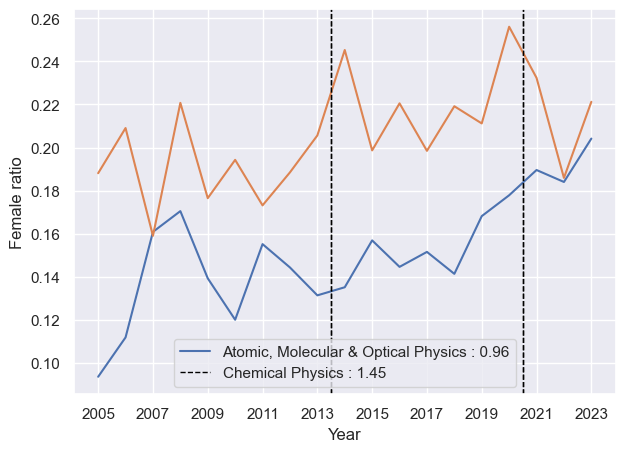

0.003619811021069349
0.004760576032877645


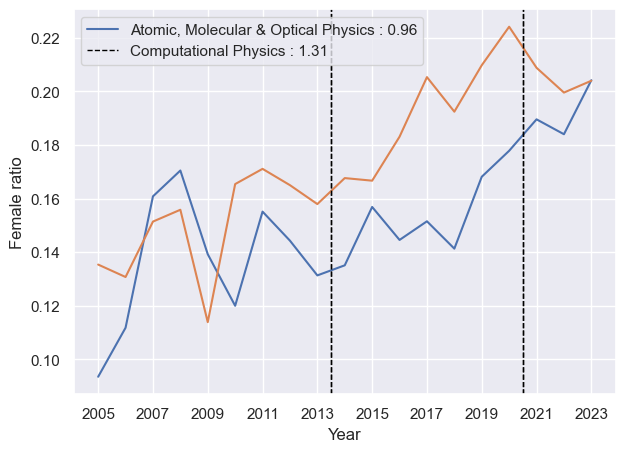

0.002184654585684913
0.0036377112161955828


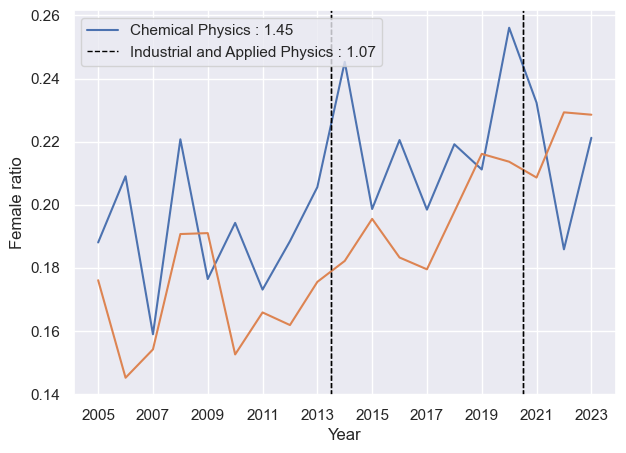

0.002184654585684913
0.0032976659714697544


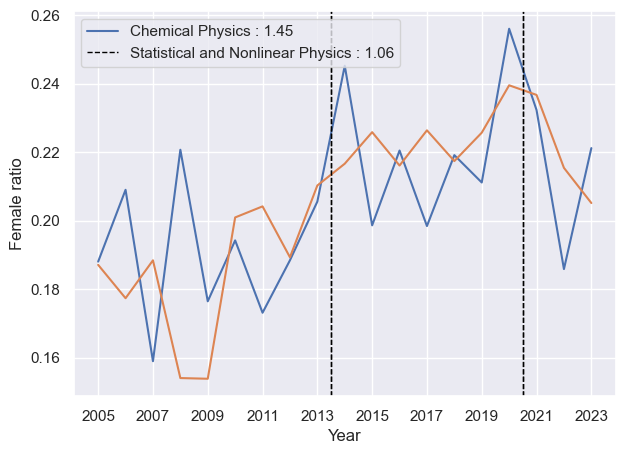

0.004760576032877645
0.0032976659714697544


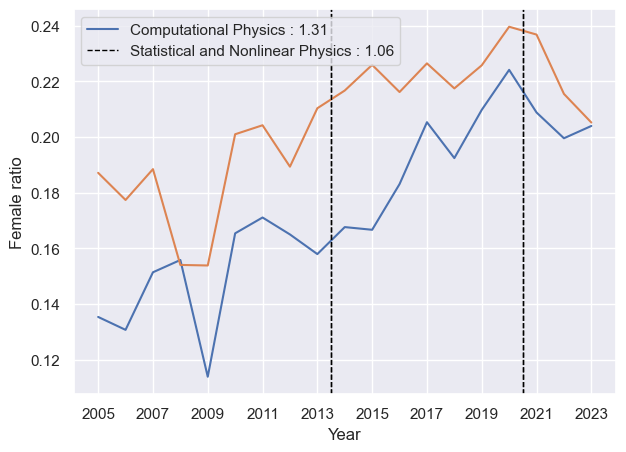

0.00434283269159297
0.0037052556478318157


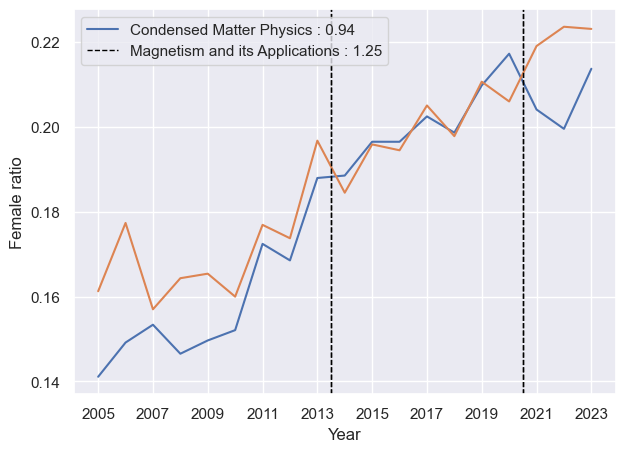

0.0035266374218203933
0.0032976659714697544


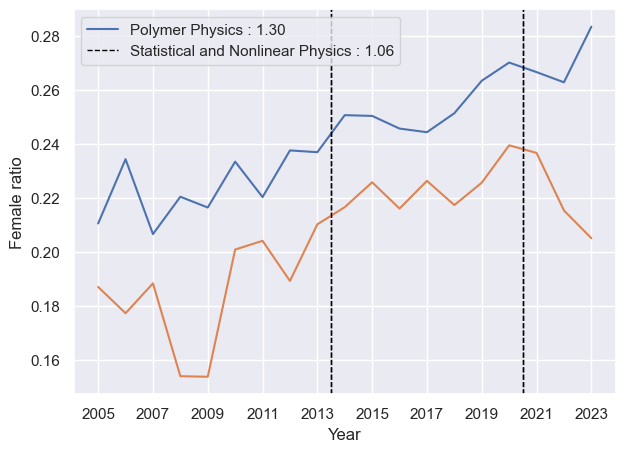

In [1704]:
unitsToPlot = mostDifferent.iloc[[0,1, 3, 4, 6, 7, 10]].to_dict('records')

for i in unitsToPlot:
    unit_i = i['SponsoringUnit']
    unit_j = i['NeighborUnit']
    
    plotGenderRatio(unit_i, unit_j, sponsUnitResearchers, interventionLikelihood)
    
    
#fix legend (line type)

In [ ]:
##difference in outcome as function of intervention

#calculate difference in outcome